In [1]:
import numpy as np
import pandas as pd 
import os

In [2]:
train_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
val_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'
test_dir='/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'
print("Path Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data"))
print("Train Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train"))
print("Test Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test"))
print("Validation Direcorty: ",os.listdir("/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid"))

Path Direcorty:  ['Thumbs.db', 'valid', 'test', 'train']
Train Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']
Test Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']
Validation Direcorty:  ['Inclusion', 'Rolled', 'Pitted', 'Scratches', 'Patches', 'Crazing']


In [3]:
print("Training Inclusion data:",len(os.listdir(train_dir+'/'+'Inclusion')))

print("Testing Inclusion data:",len(os.listdir(test_dir+'/'+'Inclusion')))

print("Validation Inclusion data:",len(os.listdir(val_dir+'/'+'Inclusion')))

Training Inclusion data: 276
Testing Inclusion data: 12
Validation Inclusion data: 12


In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 10 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [6]:
# First, we are going to load the file names and their respective target labels into numpy array! 
from sklearn.datasets import load_files
import numpy as np

test_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels
    
x_test, y_test,target_labels = load_dataset(test_dir)

In [7]:
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [8]:
from keras.utils import np_utils
y_test = np_utils.to_categorical(y_test,no_of_classes)


In [9]:
# We just have the file names in the x set. Let's load the images and convert them into array.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (72, 200, 200, 3)


In [10]:
x_test = x_test.astype('float32')/255

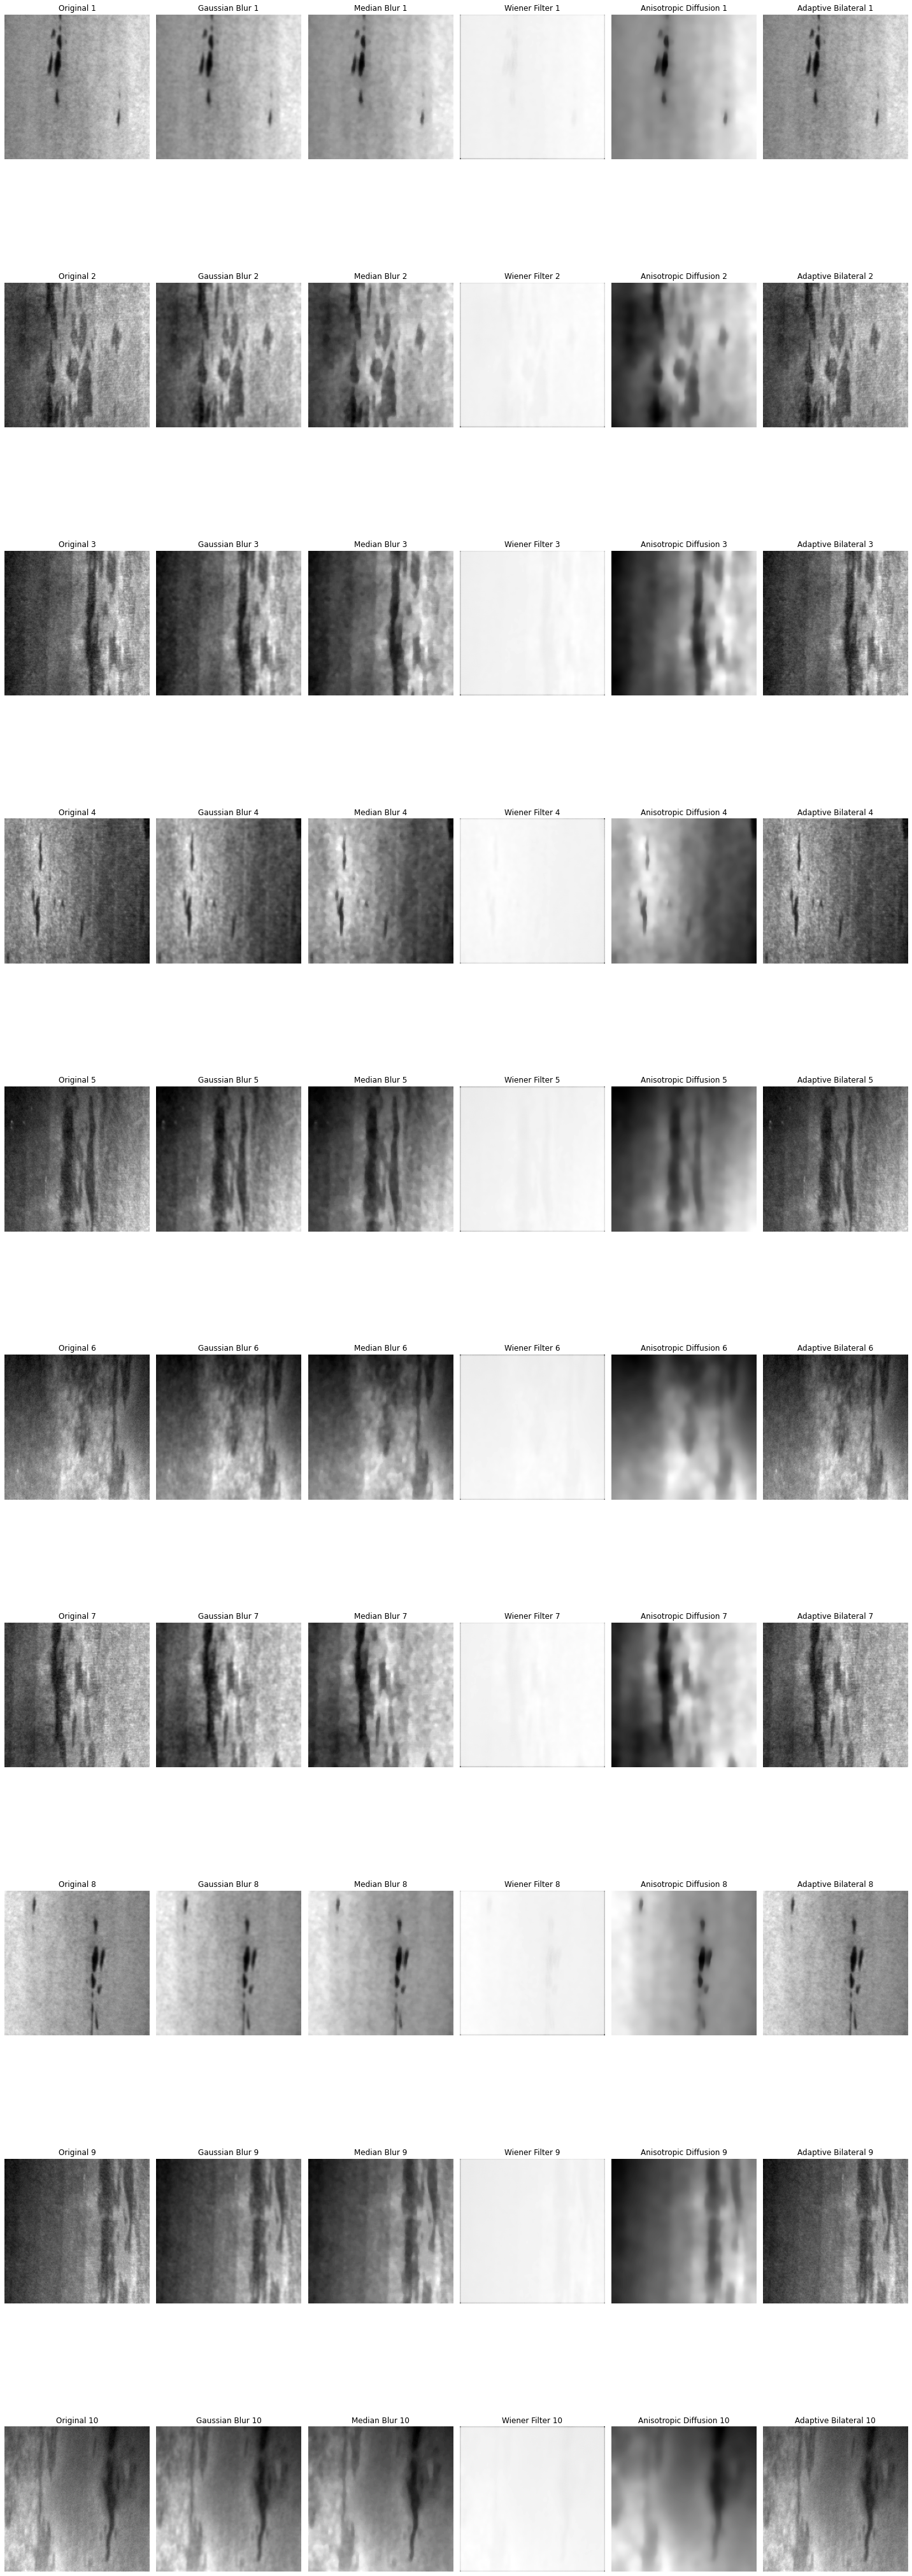

In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
from scipy.signal import wiener

# Define test directory path
test_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Inclusion'

# Get the first 5 images from the test directory
image_files = os.listdir(test_dir)[:10]

plt.figure(figsize=(20, len(image_files) * 6))

for i, image_file in enumerate(image_files):
    # Load the image
    image_path = os.path.join(test_dir, image_file)
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Standard Filters
    gaussian_blur = cv2.GaussianBlur(image, (5, 5), 0)
    median_blur = cv2.medianBlur(image, 5)

    # 🔹 **Adaptive 1: Wiener Filter (Adaptive Linear Filtering)**
    wiener_filter = wiener(image, (5, 5))  # Adaptive smoothing

    # 🔹 **Adaptive 2: Anisotropic Diffusion (Edge-preserving)**
    anisotropic_diffusion = denoise_tv_chambolle(image, weight=0.1)  # Reduces noise while keeping edges

    # 🔹 **Adaptive 3: Adaptive Bilateral Filtering**
    adaptive_bilateral = denoise_bilateral(image, sigma_color=0.1, sigma_spatial=15, multichannel=False)

    # Plot all results
    plt.subplot(len(image_files), 6, i * 6 + 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Original {i+1}')
    plt.axis('off')

    plt.subplot(len(image_files), 6, i * 6 + 2)
    plt.imshow(gaussian_blur, cmap='gray')
    plt.title(f'Gaussian Blur {i+1}')
    plt.axis('off')

    plt.subplot(len(image_files), 6, i * 6 + 3)
    plt.imshow(median_blur, cmap='gray')
    plt.title(f'Median Blur {i+1}')
    plt.axis('off')

    plt.subplot(len(image_files), 6, i * 6 + 4)
    plt.imshow(wiener_filter, cmap='gray')
    plt.title(f'Wiener Filter {i+1}')
    plt.axis('off')

    plt.subplot(len(image_files), 6, i * 6 + 5)
    plt.imshow(anisotropic_diffusion, cmap='gray')
    plt.title(f'Anisotropic Diffusion {i+1}')
    plt.axis('off')

    plt.subplot(len(image_files), 6, i * 6 + 6)
    plt.imshow(adaptive_bilateral, cmap='gray')
    plt.title(f'Adaptive Bilateral {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


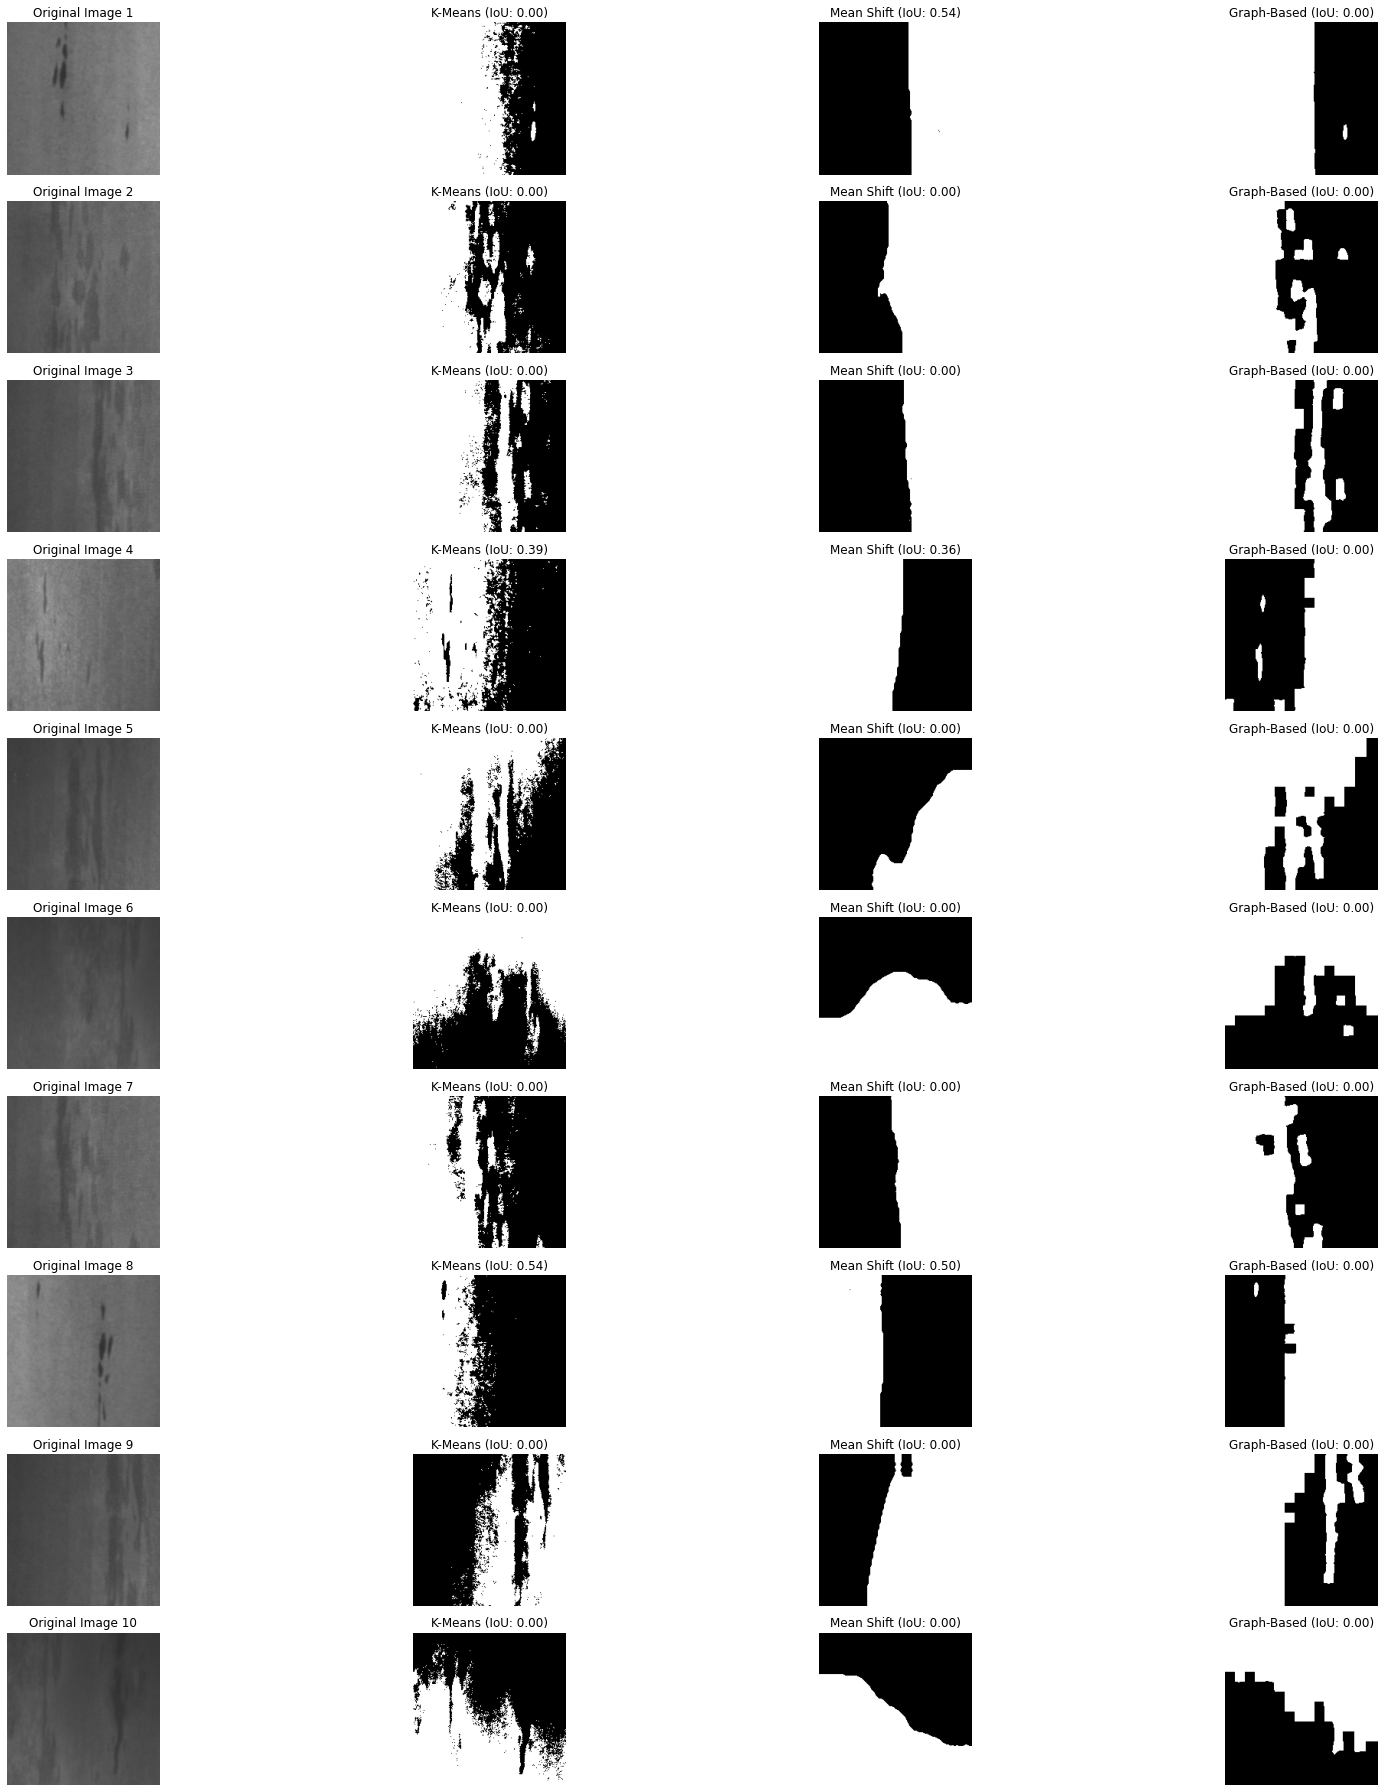

        Image  K-Means IoU  K-Means Dice  K-Means Accuracy  Mean Shift IoU  \
0   In_10.bmp      0.00000      0.000000          0.173575        0.544401   
1  In_105.bmp      0.00000      0.000000          0.531200        0.000000   
2  In_101.bmp      0.00000      0.000000          0.417400        0.000000   
3  In_107.bmp      0.39089      0.562072          0.701125        0.364487   
4  In_106.bmp      0.00000      0.000000          0.413650        0.000000   
5  In_108.bmp      0.00000      0.000000          0.462575        0.000000   
6  In_100.bmp      0.00000      0.000000          0.559900        0.000000   
7    In_1.bmp      0.53702      0.698781          0.823975        0.497624   
8  In_103.bmp      0.00000      0.000000          0.590675        0.000000   
9  In_109.bmp      0.00000      0.000000          0.540600        0.000000   

   Mean Shift Dice  Mean Shift Accuracy  Graph-Based IoU  Graph-Based Dice  \
0         0.704999             0.815300         0.000000       

In [35]:
# Enhanced Code for Best Object Extraction Based on Boundary Accuracy

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score, f1_score
from skimage import segmentation, color
import pandas as pd

# Path to test images
test_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Inclusion'
image_files = os.listdir(test_dir)[:10]  # Load first 10 images

# Function to calculate IoU, Dice, and Accuracy
def calculate_accuracy(ground_truth, segmented_image):
    # Convert images to binary (0,1)
    ground_truth = cv2.threshold(ground_truth, 127, 255, cv2.THRESH_BINARY)[1]
    segmented_image = cv2.threshold(segmented_image, 127, 255, cv2.THRESH_BINARY)[1]
    
    # Flatten images
    ground_truth = ground_truth.flatten() // 255
    segmented_image = segmented_image.flatten() // 255
    
    # Calculate IoU
    iou = jaccard_score(ground_truth, segmented_image)
    
    # Calculate Dice Coefficient
    dice = f1_score(ground_truth, segmented_image)
    
    # Calculate Pixel Accuracy
    accuracy = np.sum(ground_truth == segmented_image) / len(ground_truth)
    
    return iou, dice, accuracy

# Store results
results = []

plt.figure(figsize=(25, 25))

for i, image_file in enumerate(image_files):
    # Load image
    image_path = os.path.join(test_dir, image_file)
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # ------------------- K-Means Segmentation -------------------
    flat_image = image.reshape((-1, 3))
    kmeans = KMeans(n_clusters=2, random_state=42).fit(flat_image)
    segmented_image = kmeans.labels_.reshape(image.shape[:2])
    
    # Convert K-Means output to binary mask
    kmeans_segmented = (segmented_image * 255).astype(np.uint8)
    
    # ------------------- Mean Shift Segmentation -------------------
    mean_shift = cv2.pyrMeanShiftFiltering(image, sp=30, sr=50)
    mean_shift_gray = cv2.cvtColor(mean_shift, cv2.COLOR_BGR2GRAY)
    _, mean_shift_segmented = cv2.threshold(mean_shift_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # ------------------- Graph-Based Segmentation -------------------
    segments = slic(image, n_segments=250, compactness=10, sigma=1)
    graph_segmented = mark_boundaries(image_rgb, segments)
    graph_binary = (color.label2rgb(segments, image_gray, kind='avg') * 255).astype(np.uint8)
    _, graph_segmented = cv2.threshold(graph_binary, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # ------------------- Calculate Accuracy -------------------
    iou_kmeans, dice_kmeans, acc_kmeans = calculate_accuracy(image_gray, kmeans_segmented)
    iou_mean, dice_mean, acc_mean = calculate_accuracy(image_gray, mean_shift_segmented)
    iou_graph, dice_graph, acc_graph = calculate_accuracy(image_gray, graph_segmented)
    
    # Store Results
    results.append({
        'Image': image_file,
        'K-Means IoU': iou_kmeans, 'K-Means Dice': dice_kmeans, 'K-Means Accuracy': acc_kmeans,
        'Mean Shift IoU': iou_mean, 'Mean Shift Dice': dice_mean, 'Mean Shift Accuracy': acc_mean,
        'Graph-Based IoU': iou_graph, 'Graph-Based Dice': dice_graph, 'Graph-Based Accuracy': acc_graph
    })
    
    # ------------------- Plot Results -------------------
    plt.subplot(len(image_files), 4, i*4+1)
    plt.imshow(image_rgb)
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(len(image_files), 4, i*4+2)
    plt.imshow(kmeans_segmented, cmap='gray')
    plt.title(f'K-Means (IoU: {iou_kmeans:.2f})')
    plt.axis('off')
    
    plt.subplot(len(image_files), 4, i*4+3)
    plt.imshow(mean_shift_segmented, cmap='gray')
    plt.title(f'Mean Shift (IoU: {iou_mean:.2f})')
    plt.axis('off')
    
    plt.subplot(len(image_files), 4, i*4+4)
    plt.imshow(graph_segmented, cmap='gray')
    plt.title(f'Graph-Based (IoU: {iou_graph:.2f})')
    plt.axis('off')

plt.tight_layout()
plt.show()

# ------------------- Recommend Best Method -------------------
best_method = []
for res in results:
    iou_scores = [res['K-Means IoU'], res['Mean Shift IoU'], res['Graph-Based IoU']]
    methods = ['K-Means', 'Mean Shift', 'Graph-Based']
    best_index = np.argmax(iou_scores)
    best_method.append(methods[best_index])

# Add Best Method to Results
df = pd.DataFrame(results)
df['Best Method'] = best_method

# Display Results
print(df)

# ------------------- Save Results as CSV -------------------
df.to_csv('/kaggle/working/segmentation_results.csv', index=False)

# ------------------- Best Method Summary -------------------
best_counts = df['Best Method'].value_counts()
print("\n\n Best Method Summary:")
print(best_counts)

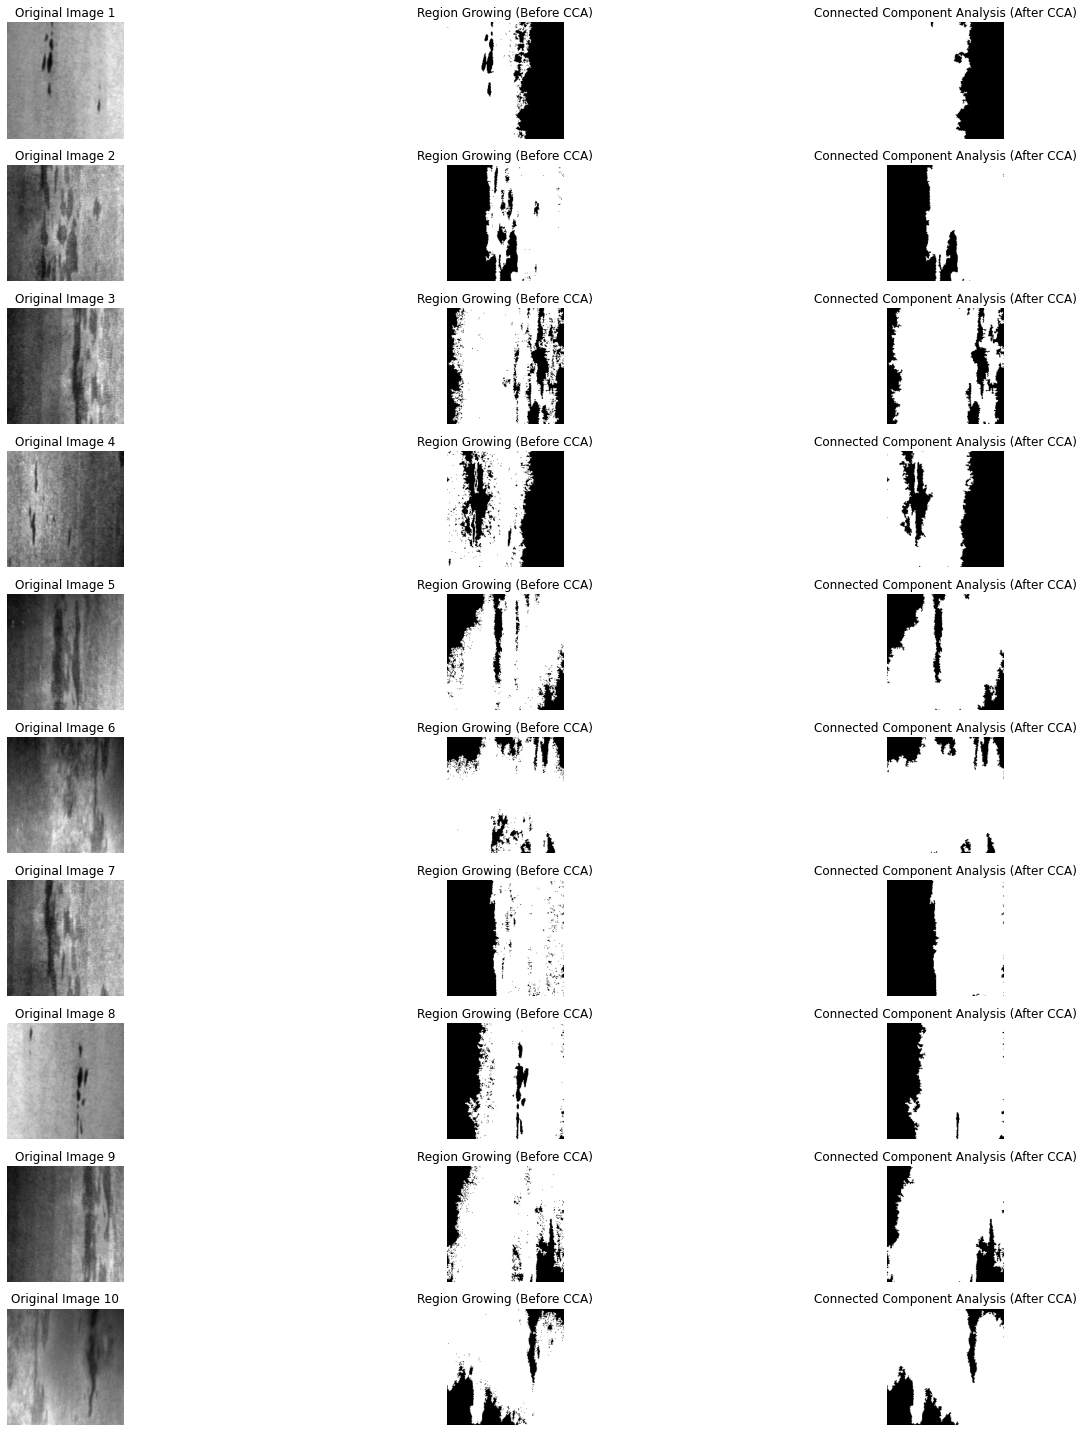

In [15]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score, f1_score
from skimage import segmentation, color
import pandas as pd
from skimage.measure import label, regionprops
from scipy.ndimage import binary_fill_holes



# Path to test images
test_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Inclusion'
image_files = os.listdir(test_dir)[:10]  # Load first 10 images

# ---------------------- Region Growing Algorithm -------------------------
def region_growing(image, seed_point):
    # Convert to grayscale if not already
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Parameters
    height, width = image.shape
    segmented = np.zeros_like(image, dtype=np.uint8)
    visited = np.zeros_like(image, dtype=bool)
    
    # Threshold for region growing
    threshold = 15
    
    # Stack to store pixels to process
    stack = [seed_point]
    initial_intensity = image[seed_point]
    
    # Perform Region Growing
    while stack:
        x, y = stack.pop()
        if visited[x, y]:
            continue
        
        # Check intensity difference
        if abs(int(image[x, y]) - int(initial_intensity)) < threshold:
            segmented[x, y] = 255
            visited[x, y] = True
            
            # Push 4-connected neighbors
            if x > 0: stack.append((x-1, y))
            if x < height-1: stack.append((x+1, y))
            if y > 0: stack.append((x, y-1))
            if y < width-1: stack.append((x, y+1))
    
    return segmented

# ---------------------- Connected Component Analysis -------------------------
def connected_component_analysis(image):
    # Label connected components
    labeled_image = label(image)
    props = regionprops(labeled_image)
    
    # Remove small objects (noise)
    min_size = 500
    cleaned_image = np.zeros_like(image, dtype=np.uint8)
    
    for region in props:
        if region.area >= min_size:
            for coord in region.coords:
                cleaned_image[coord[0], coord[1]] = 255
    
    # Fill holes to enhance objects
    cleaned_image = binary_fill_holes(cleaned_image).astype(np.uint8) * 255
    
    return cleaned_image

# ---------------------- Apply Both Algorithms -------------------------
plt.figure(figsize=(20, 20))

for i, image_file in enumerate(image_files):
    # Load image
    image_path = os.path.join(test_dir, image_file)
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # ---------------------- Step 1: Apply Region Growing -------------------------
    seed_point = (image_gray.shape[0]//2, image_gray.shape[1]//2)
    region_grown_image = region_growing(image_gray, seed_point)
    
    # ---------------------- Step 2: Apply Connected Component Analysis -------------------------
    cleaned_image = connected_component_analysis(region_grown_image)
    
    # ---------------------- Plot Results -------------------------
    plt.subplot(len(image_files), 3, i*3+1)
    plt.imshow(image_gray, cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(len(image_files), 3, i*3+2)
    plt.imshow(region_grown_image, cmap='gray')
    plt.title(f'Region Growing (Before CCA)')
    plt.axis('off')
    
    plt.subplot(len(image_files), 3, i*3+3)
    plt.imshow(cleaned_image, cmap='gray')
    plt.title(f'Connected Component Analysis (After CCA)')
    plt.axis('off')

plt.tight_layout()
plt.show()



--- Image 1: In_10.bmp ---
K-Means:     IoU=0.9127, Dice=0.9544, Accuracy=0.9638
Mean Shift:  IoU=0.4020, Dice=0.5734, Accuracy=0.4134
Graph-Based: IoU=0.0000, Dice=0.0000, Accuracy=0.6057

--- Image 2: In_105.bmp ---
K-Means:     IoU=0.3936, Dice=0.5649, Accuracy=0.4455
Mean Shift:  IoU=0.2641, Dice=0.4179, Accuracy=0.2990
Graph-Based: IoU=0.0000, Dice=0.0000, Accuracy=0.4688

--- Image 3: In_101.bmp ---
K-Means:     IoU=0.6728, Dice=0.8044, Accuracy=0.7970
Mean Shift:  IoU=0.0979, Dice=0.1783, Accuracy=0.0979
Graph-Based: IoU=0.0000, Dice=0.0000, Accuracy=0.5826

--- Image 4: In_107.bmp ---
K-Means:     IoU=0.2664, Dice=0.4207, Accuracy=0.3489
Mean Shift:  IoU=0.2076, Dice=0.3438, Accuracy=0.2677
Graph-Based: IoU=0.0000, Dice=0.0000, Accuracy=0.5093

--- Image 5: In_106.bmp ---
K-Means:     IoU=0.6960, Dice=0.8207, Accuracy=0.8193
Mean Shift:  IoU=0.2246, Dice=0.3668, Accuracy=0.3647
Graph-Based: IoU=0.0000, Dice=0.0000, Accuracy=0.5864

--- Image 6: In_108.bmp ---
K-Means:     IoU=

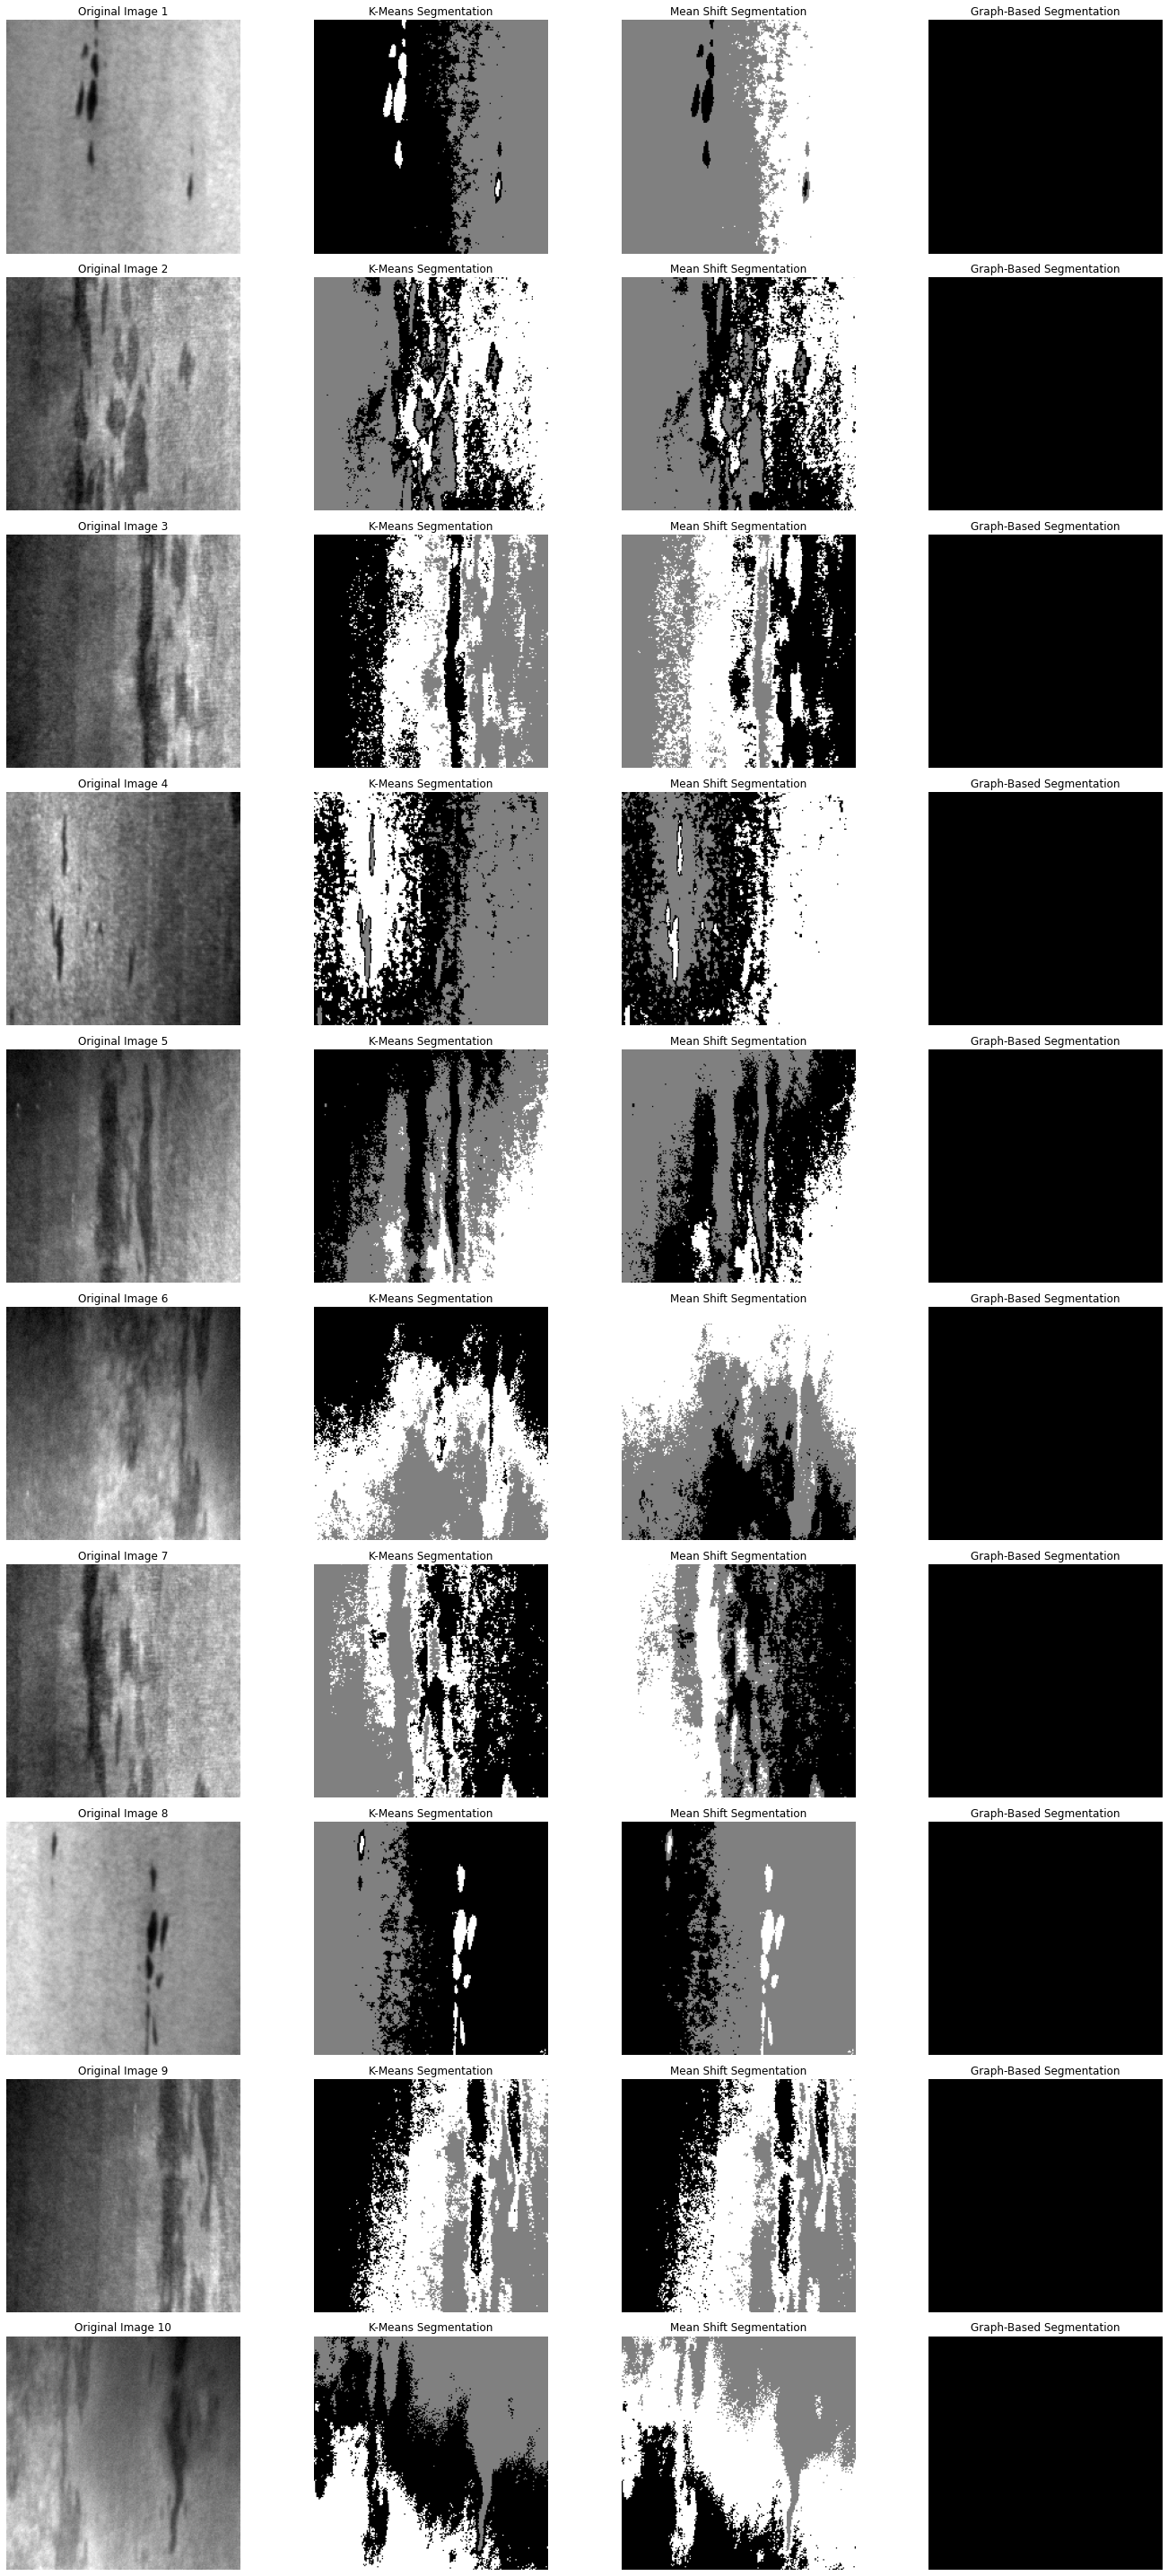

In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic, mark_boundaries
from skimage.future import graph
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects, binary_closing, disk
from skimage.color import rgb2lab
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score, f1_score

# ---------------------- Load Images -------------------------
test_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Inclusion'
image_files = os.listdir(test_dir)[:10]  # Load first 10 images

# ---------------------- Improved Graph-Based Segmentation -------------------------
def improved_graph_segmentation(image, n_segments=300, compactness=15, rag_threshold=20):
    """Enhanced Graph-based segmentation using SLIC and RAG Thresholding."""
    # Convert image to Lab color space for better color distinction
    image_lab = rgb2lab(image)

    # Apply SLIC superpixel segmentation (without `start_label`)
    labels = slic(image_lab, n_segments=n_segments, compactness=compactness, sigma=1)
    
    # Ensure labels start from 1 (if needed)
    labels += 1  

    # Create Region Adjacency Graph (RAG)
    g = graph.rag_mean_color(image, labels, mode='similarity')

    # Merge similar regions based on a threshold
    labels2 = graph.cut_threshold(labels, g, rag_threshold)
    
    return labels2


# ---------------------- Segmentation Functions -------------------------

def kmeans_segmentation(image_gray, n_clusters=3):
    """Applies K-Means clustering to segment the grayscale image."""
    reshaped = image_gray.reshape(-1, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(reshaped)
    segmented = labels.reshape(image_gray.shape)
    return segmented

def mean_shift_segmentation(image_gray):
    """Applies Mean Shift segmentation using OpenCV."""
    img_reshaped = image_gray.reshape(-1, 1).astype(np.float32)
    _, labels, _ = cv2.kmeans(img_reshaped, 3, None, (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0), 10, cv2.KMEANS_RANDOM_CENTERS)
    return labels.reshape(image_gray.shape)

# ---------------------- Post-processing -------------------------
def optimized_post_process(segmented):
    """Enhances segmentation using morphological operations."""
    segmented = remove_small_objects(segmented.astype(bool), min_size=250)
    segmented = binary_closing(segmented, disk(2))
    return segmented.astype(np.uint8)

# ---------------------- Evaluation Function -------------------------
def calculate_metrics_auto(image_gray, segmented_image):
    """Evaluates segmentation without ground truth using auto-thresholding."""
    thresh_value = threshold_otsu(image_gray)
    auto_threshold_mask = (image_gray > thresh_value).astype(np.uint8)

    # Convert to boolean for metric computation
    auto_threshold_mask = auto_threshold_mask.astype(bool)
    segmented_image = segmented_image.astype(bool)

    # Compute IoU, Dice, and Accuracy
    iou = jaccard_score(auto_threshold_mask.flatten(), segmented_image.flatten())
    dice = f1_score(auto_threshold_mask.flatten(), segmented_image.flatten())
    accuracy = np.mean(auto_threshold_mask == segmented_image)

    return iou, dice, accuracy

# ---------------------- Processing All Images -------------------------
plt.figure(figsize=(20, 40))

for i, image_file in enumerate(image_files):
    # Load image
    image_path = os.path.join(test_dir, image_file)
    image = cv2.imread(image_path)
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply segmentation methods
    kmeans_segmented = kmeans_segmentation(image_gray)
    mean_shift_segmented = mean_shift_segmentation(image_gray)
    graph_segmented = improved_graph_segmentation(image)

    # Post-processing
    graph_segmented = optimized_post_process(graph_segmented)

    # Evaluate segmentation
    iou_kmeans, dice_kmeans, acc_kmeans = calculate_metrics_auto(image_gray, kmeans_segmented)
    iou_meanshift, dice_meanshift, acc_meanshift = calculate_metrics_auto(image_gray, mean_shift_segmented)
    iou_graph, dice_graph, acc_graph = calculate_metrics_auto(image_gray, graph_segmented)

    # Print scores for each image
    print(f"\n--- Image {i+1}: {image_file} ---")
    print(f"K-Means:     IoU={iou_kmeans:.4f}, Dice={dice_kmeans:.4f}, Accuracy={acc_kmeans:.4f}")
    print(f"Mean Shift:  IoU={iou_meanshift:.4f}, Dice={dice_meanshift:.4f}, Accuracy={acc_meanshift:.4f}")
    print(f"Graph-Based: IoU={iou_graph:.4f}, Dice={dice_graph:.4f}, Accuracy={acc_graph:.4f}")

    # Plot results
    plt.subplot(len(image_files), 4, i*4+1)
    plt.imshow(image_gray, cmap='gray')
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    plt.subplot(len(image_files), 4, i*4+2)
    plt.imshow(kmeans_segmented, cmap='gray')
    plt.title(f'K-Means Segmentation')
    plt.axis('off')

    plt.subplot(len(image_files), 4, i*4+3)
    plt.imshow(mean_shift_segmented, cmap='gray')
    plt.title(f'Mean Shift Segmentation')
    plt.axis('off')

    plt.subplot(len(image_files), 4, i*4+4)
    plt.imshow(graph_segmented, cmap='gray')
    plt.title(f'Graph-Based Segmentation')
    plt.axis('off')

plt.tight_layout()
plt.show()
